In [ ]:
"""
Master's Dissertation: Resilient Supply Chains: AI-Driven Risk Mitigation through Predictive Modelling and Risk Assessment Scorecard

This script develops an integrated AI-driven framework to predict transportation and logistics delays
in supply chains, providing actionable risk assessment scores to enhance resilience. It follows
the CRISP-DM methodology through distinct phases: Data Understanding, Data Preparation, Modeling,
and Evaluation.

The framework generates two primary machine learning predictions:
1. Probability of Delay (binary classification).
2. Delay Severity Score (multi-class classification: 0, 1, or 2).

These predictions are then integrated into a dynamic Risk Assessment Scorecard, alongside
rule-based cargo criticality and business impact calculations, for comprehensive risk assessment
and strategic insights.

Developer: Aisyah Ariana Binti Hamdan
Warwick ID: 5656745
"""

"\nMaster's Dissertation: Resilient Supply Chains: AI-Driven Risk Mitigation through Predictive Modelling and Risk Assessment Scorecard\n\nThis script develops an integrated AI-driven framework to predict transportation and logistics delays\nin supply chains, providing actionable risk assessment scores to enhance resilience. It follows\nthe CRISP-DM methodology through distinct phases: Data Understanding, Data Preparation, Modeling,\nand Evaluation.\n\nThe framework generates two primary machine learning predictions:\n1. Probability of Delay (binary classification).\n2. Delay Severity Score (multi-class classification: 0, 1, or 2).\n\nThese predictions are then integrated into a dynamic Risk Assessment Scorecard, alongside\nrule-based cargo criticality and business impact calculations, for comprehensive risk assessment\nand strategic insights.\n\nDeveloper: Aisyah Ariana Binti Hamdan\nWarwick ID: 5656745\n"

## **Data Dictionary**

The data description and data dictionary below is taken from the dataset source (Kaggle) at https://www.kaggle.com/datasets/zoya77/multi-modal-data-for-supply-chain-risk-management/data

*The dataset contains information sourced from various supply chain systems, including sensors, logistics data, and external feeds like weather and social media. Each record represents a unique snapshot of operational data from a specific time and location. The dataset integrates several types of data, such as environmental conditions, inventory levels, and delivery performance, to predict the likelihood of supply chain risks. The target column labels each instance based on the severity of the identified risks, which are categorized as low, medium, or high. It allows for real-time analysis and decision-making in complex, fast-changing environments.*

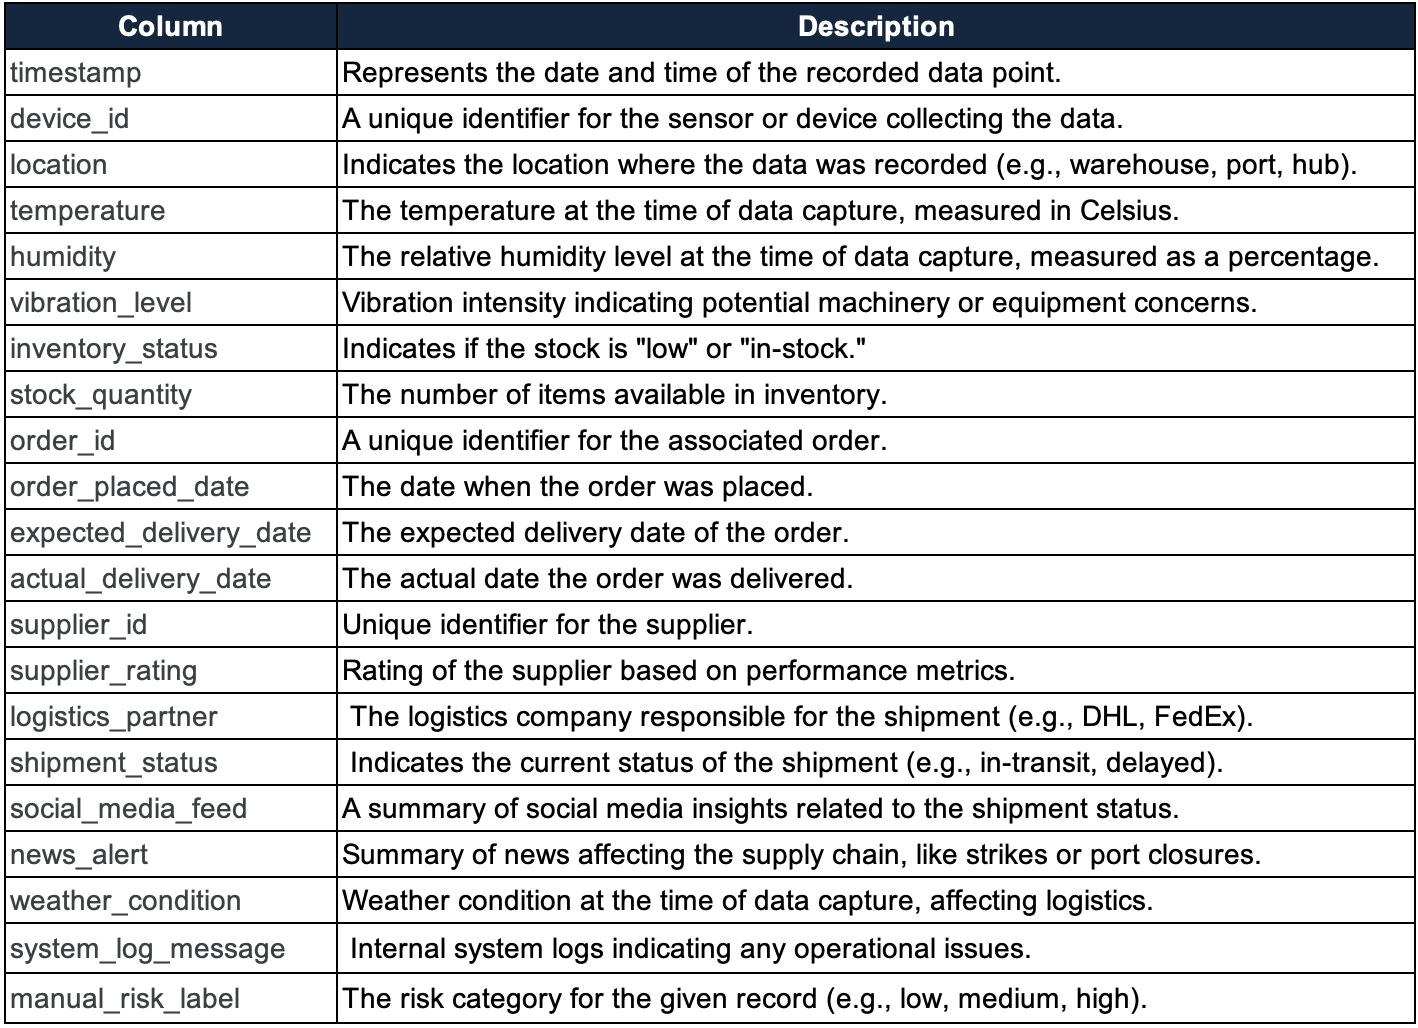

In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os # For TF_CPP_MIN_LOG_LEVEL environment variable

# --- Visualisation Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning Libraries (Scikit-learn) ---
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, make_scorer, precision_recall_curve
)

# --- Machine Learning Libraries (XGBoost) ---
from xgboost import XGBClassifier

# --- Machine Learning Libraries (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping as KerasEarlyStopping

# --- Utility Libraries ---
import joblib # For saving/loading models and data
import warnings # For suppressing specific warnings

# --- Global Settings ---
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow INFO/WARNING messages
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.titlesize': 14})
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## **Phase 2: Data Understanding**

In [ ]:
# Load Dataset
df_raw = pd.read_csv('supply_chain_risk_dataset.csv')
df = df_raw.copy() # Work on a copy to preserve original raw data

In [ ]:
# Initial Data Inspection and Datetime Conversion
print("\n  Initial Data Inspection & Datetime Conversion")
print("\n  DataFrame Head:")
display(df.head())

print("\n  DataFrame Info (Before Datetime Conversion):")
df.info()

datetime_cols = ['timestamp', 'order_placed_date', 'expected_delivery_date', 'actual_delivery_date']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if df[col].isnull().any():
            print(f"  Warning: NaT values introduced in '{col}' after datetime conversion. Investigation needed.")

print("\n  DataFrame Info (After Datetime Conversion):")
df.info()

print("\n  Descriptive Statistics for Numerical Columns:")
display(df.describe())
print(f"\n  DataFrame Shape: {df.shape[0]} rows, {df.shape[1]} columns")


# Rigorous Data Quality Checks
print("\n--- Rigorous Data Quality Checks ---")

# Check for Duplicate Rows
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"  Detected {num_duplicates} duplicate rows. Removing...")
    df.drop_duplicates(inplace=True)
    print(f"  Removed {num_duplicates} duplicate rows. New shape: {df.shape}")
else:
    print("  No duplicate rows detected.")


# Check for impossible date sequences (e.g., delivery before order placement)
temp_df_for_check = df.copy()
impossible_order_sequence = temp_df_for_check[temp_df_for_check['actual_delivery_date'] < temp_df_for_check['order_placed_date']]
print(f"\n  Number of rows where actual delivery is before order placement: {len(impossible_order_sequence)}")

impossible_expectation = temp_df_for_check[temp_df_for_check['expected_delivery_date'] < temp_df_for_check['order_placed_date']]
print(f"  Number of rows where expected delivery is before order placement: {len(impossible_expectation)}")


# Check numerical column ranges (confirming physical plausibility)
print("\n  Numerical Column Range Checks (from df.describe()):")
print(f"    Supplier Rating: Min={df['supplier_rating'].min()}, Max={df['supplier_rating'].max()} (Expected: 1-5)")
print(f"    Temperature: Min={df['temperature'].min()}, Max={df['temperature'].max()} (Expected: plausible range)")
print(f"    Humidity: Min={df['humidity'].min()}, Max={df['humidity'].max()} (Expected: 0-100%)")
print(f"    Stock Quantity: Min={df['stock_quantity'].min()} (Expected: >=0)")


# Categorical Value Consistency & Standardization
print("\n--- Categorical Value Consistency & Standardization ---")

df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('[^A-Za-z0-9_]+', '', regex=True)
print(f"  Standardized columns: {df.columns.tolist()}")

string_object_cols_for_cleaning = df.select_dtypes(include='object').columns.tolist()
if string_object_cols_for_cleaning:
    for col in string_object_cols_for_cleaning:
        df[col] = df[col].astype(str).str.strip().str.lower().str.replace(' ', '_')
        print(f"    Cleaned string values in '{col}'. Example: {df[col].unique()[:5]}")
    print("  All relevant string/object columns cleaned.")

categorical_cols_to_convert = [
    'location', 'inventory_status', 'logistics_partner', 'shipment_status',
    'social_media_feed', 'news_alert', 'weather_condition', 'system_log_message',
    'device_id', 'order_id', 'supplier_id'
]
for col in categorical_cols_to_convert:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        print(f"    '{col}' converted to 'category' dtype. Unique values: {df[col].nunique()}")


# Consistency Checks Between Related Columns
print("\n--- Consistency Checks Between Related Columns ---")
print("  Descriptive stats for Stock Quantity when Inventory Status is 'low':")
print(df[df['inventory_status'] == 'low']['stock_quantity'].describe())

delivered_but_no_date = df[(df['shipment_status'] == 'delivered') & (df['actual_delivery_date'].isnull())]
print(f"\n  Number of shipments marked 'delivered' but have no delivery date: {len(delivered_but_no_date)}")
if len(delivered_but_no_date) > 0:
    print("  --> INVESTIGATE: These rows have inconsistent data.")

print("\n--- Phase 2: Data Understanding Complete ---")


  Initial Data Inspection & Datetime Conversion

  DataFrame Head:


,timestamp,device_id,location,temperature,humidity,vibration_level,inventory_status,stock_quantity,order_id,order_placed_date,...,actual_delivery_date,supplier_id,supplier_rating,logistics_partner,shipment_status,social_media_feed,news_alert,weather_condition,system_log_message,manual_risk_label
0,2024-03-27 11:21:41,sensor_2,Hub_C,27.48,48.62,1.98,in-stock,188,ORD5506,2024-03-19 11:21:41,...,2024-03-29 11:21:41,SUP_117,2.78,DHL,delivered,Supply chain normal,Stable market,sunny,System normal,0
1,2025-02-27 14:22:08,sensor_6,Hub_C,24.53,40.71,0.61,in-stock,359,ORD7912,2025-02-22 14:22:08,...,2025-03-02 14:22:08,SUP_111,1.08,FedEx,in-transit,Supply chain normal,Stable market,sunny,System normal,0
2,2025-01-27 12:30:19,sensor_39,Warehouse_A,22.10,44.75,0.30,in-stock,459,ORD4257,2025-01-12 12:30:19,...,2025-01-29 12:30:19,SUP_153,1.03,FedEx,delayed,Supply chain normal,Stable market,sunny,System normal,0
3,2025-04-02 16:42:30,sensor_18,Warehouse_A,25.11,45.72,0.77,in-stock,475,ORD3615,2025-03-22 16:42:30,...,2025-04-22 16:42:30,SUP_135,1.93,FedEx,in-transit,Possible delay reported,Minor strikes reported,rainy,Warning threshold exceeded,1
4,2024-09-18 10:34:37,sensor_7,Warehouse_A,26.11,42.32,0.72,in-stock,243,ORD7224,2024-09-12 10:34:37,...,2024-09-20 10:34:37,SUP_144,1.19,UPS,in-transit,Supply chain normal,Stable market,sunny,System normal,0



  DataFrame Info (Before Datetime Conversion):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               3000 non-null   object 
 1   device_id               3000 non-null   object 
 2   location                3000 non-null   object 
 3   temperature             3000 non-null   float64
 4   humidity                3000 non-null   float64
 5   vibration_level         3000 non-null   float64
 6   inventory_status        3000 non-null   object 
 7   stock_quantity          3000 non-null   int64  
 8   order_id                3000 non-null   object 
 9   order_placed_date       3000 non-null   object 
 10  expected_delivery_date  3000 non-null   object 
 11  actual_delivery_date    3000 non-null   object 
 12  supplier_id             3000 non-null   object 
 13  supplier_rating         3000 non-null   float

,timestamp,temperature,humidity,vibration_level,stock_quantity,order_placed_date,expected_delivery_date,actual_delivery_date,supplier_rating,manual_risk_label
count,3000,3000.000000,3000.000000,3000.000000,3000.000000,3000,3000,3000,3000.000000,3000.000000
mean,2024-09-03 07:50:00.928000,24.895820,49.945477,1.481863,249.599667,2024-08-24 09:39:27.327999744,2024-09-06 08:22:39.328000,2024-09-06 20:14:00.927999744,2.992870,0.334333
min,2024-01-01 09:59:25,7.600000,16.120000,0.000000,0.000000,2023-12-20 16:33:25,2024-01-02 10:38:08,2024-01-01 09:59:25,1.000000,0.000000
25%,2024-04-30 23:06:53.500000,21.407500,43.137500,0.400000,124.000000,2024-04-20 16:33:50.500000,2024-05-03 19:55:40.249999872,2024-05-03 08:42:04,1.990000,0.000000
50%,2024-09-01 00:15:57,24.950000,50.090000,1.020000,250.000000,2024-08-23 00:15:57,2024-09-03 11:25:21,2024-09-03 14:56:56.500000,2.990000,0.000000
75%,2025-01-07 00:51:37.249999872,28.440000,56.780000,2.052500,374.000000,2024-12-27 06:29:44.249999872,2025-01-09 23:09:19.249999872,2025-01-10 11:13:43.500000,3.980000,1.000000
max,2025-05-07 16:03:20,42.090000,80.870000,13.200000,499.000000,2025-05-01 08:51:31,2025-05-12 06:40:25,2025-05-22 08:13:11,5.000000,2.000000
std,NaN,5.188619,10.198968,1.501984,144.333108,NaN,NaN,NaN,1.151905,0.493257



  DataFrame Shape: 3000 rows, 21 columns

--- Rigorous Data Quality Checks ---
  No duplicate rows detected.

  Number of rows where actual delivery is before order placement: 0
  Number of rows where expected delivery is before order placement: 0

  Numerical Column Range Checks (from df.describe()):
    Supplier Rating: Min=1.0, Max=5.0 (Expected: 1-5)
    Temperature: Min=7.6, Max=42.09 (Expected: plausible range)
    Humidity: Min=16.12, Max=80.87 (Expected: 0-100%)
    Stock Quantity: Min=0 (Expected: >=0)

--- Categorical Value Consistency & Standardization ---
  Standardized columns: ['timestamp', 'device_id', 'location', 'temperature', 'humidity', 'vibration_level', 'inventory_status', 'stock_quantity', 'order_id', 'order_placed_date', 'expected_delivery_date', 'actual_delivery_date', 'supplier_id', 'supplier_rating', 'logistics_partner', 'shipment_status', 'social_media_feed', 'news_alert', 'weather_condition', 'system_log_message', 'manual_risk_label']
    Cleaned string val

## **Phase 3: Data Preparation**


  'shipment_id' created. Example: 0    SHP00000
1    SHP00001
2    SHP00002
3    SHP00003
4    SHP00004
Name: shipment_id, dtype: object

--- Target Variable Creation ---
  'is_delayed' classification target created. Value counts: 
is_delayed
1    1599
0    1401
Name: count, dtype: int64
  Delay percentage: 53.30%


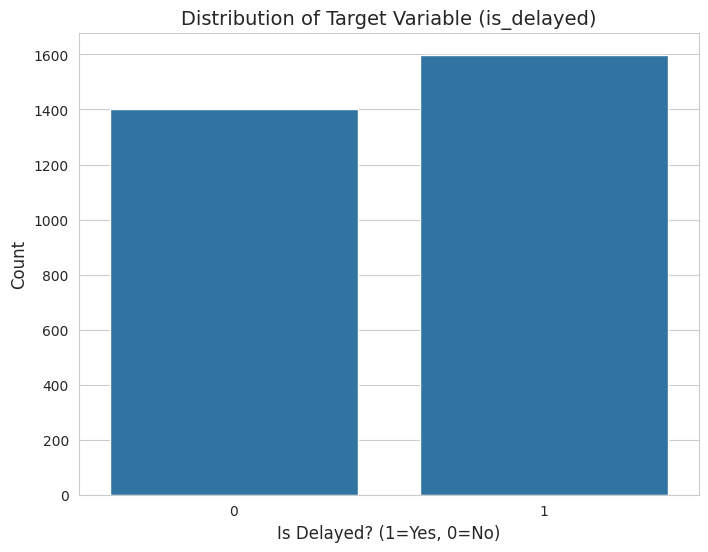

is_delayed
1    0.533
0    0.467
Name: proportion, dtype: float64
  'delay_duration_hours' intermediate calculation. Descriptive statistics: 
count    3000.000000
mean       49.672000
std       109.970849
min         0.000000
25%         0.000000
50%         0.000000
75%        24.000000
max       456.000000
Name: delay_duration_hours, dtype: float64

--- Delay Severity Classification Target Transformation ---
  'delay_severity_score' created based on duration bins (revised to 0-2 scale). Value counts: 
delay_severity_score
0    1401
1     930
2     669
Name: count, dtype: int64


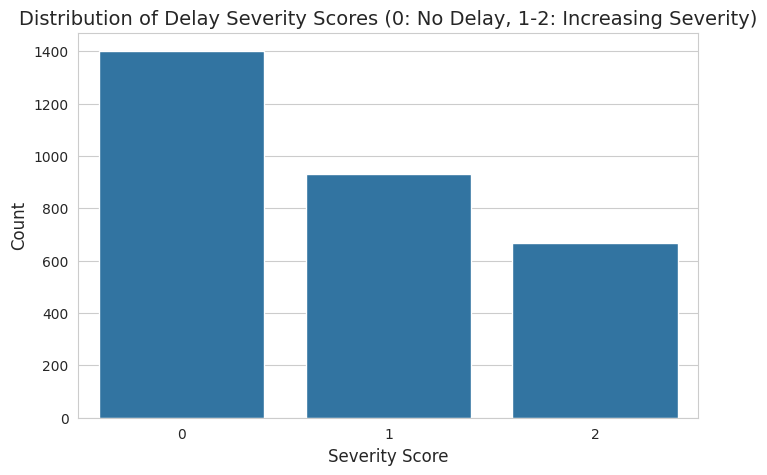

In [ ]:
# Create Stable Unique Shipment ID
df['shipment_id'] = df.index.map(lambda i: f"SHP{i:05d}")
print(f"\n  'shipment_id' created. Example: {df['shipment_id'].head()}")

# Target Variable Creation
print("\n--- Target Variable Creation ---")

df['date_delay_hours'] = (df['actual_delivery_date'] - df['expected_delivery_date']).dt.total_seconds() / 3600

# Define 'is_delayed' as the binary classification target
# A shipment is considered delayed if its actual_delivery_date is > 1 hour after expected_delivery_date
# OR its shipment_status explicitly indicates 'delayed'. This enhances recall.
df['is_delayed'] = 0
df.loc[df['date_delay_hours'] > 1, 'is_delayed'] = 1
df.loc[df['shipment_status'] == 'delayed', 'is_delayed'] = 1
df['is_delayed'] = df['is_delayed'].astype(int)

print(f"  'is_delayed' classification target created. Value counts: \n{df['is_delayed'].value_counts()}")
print(f"  Delay percentage: {df['is_delayed'].mean() * 100:.2f}%")

# Distribution of the main target variable 'is_delayed'
plt.figure(figsize=(8, 6))
sns.countplot(x='is_delayed', data=df)
plt.title('Distribution of Target Variable (is_delayed)')
plt.xlabel('Is Delayed? (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()
print(df['is_delayed'].value_counts(normalize=True))

# 'delay_duration_hours' is an intermediate calculation for the severity score, ensuring non-negative values.
df['delay_duration_hours'] = df['date_delay_hours'].apply(lambda x: max(0, x))
print(f"  'delay_duration_hours' intermediate calculation. Descriptive statistics: \n{df['delay_duration_hours'].describe()}")


# Target Variable Transformation for Delay Severity Classification
print("\n--- Delay Severity Classification Target Transformation ---")

# Define bins for delay duration, aligning with a 0-2 score (0: No Delay, 1: Low-Moderate, 2: High-Severe).
bins = [-0.001, 24, np.inf] # Bins: (>0 to 24 hours], (>24 hours to infinity)
labels = [1, 2] # Corresponding severity scores for actual delays (renumbered)

df['delay_severity_score'] = 0 # Default to 0 for non-delayed
df.loc[df['is_delayed'] == 1, 'delay_severity_score'] = pd.cut(
    df.loc[df['is_delayed'] == 1, 'delay_duration_hours'],
    bins=bins,
    labels=labels,
    right=True, # Interval includes the rightmost edge
    include_lowest=True # To include 0 for the first bin boundary, for values very close to 0 in score 1
).astype(int)

print(f"  'delay_severity_score' created based on duration bins (revised to 0-2 scale). Value counts: \n{df['delay_severity_score'].value_counts().sort_index()}")

plt.figure(figsize=(8, 5))
sns.countplot(x='delay_severity_score', data=df, order=sorted(df['delay_severity_score'].unique()))
plt.title('Distribution of Delay Severity Scores (0: No Delay, 1-2: Increasing Severity)')
plt.xlabel('Severity Score')
plt.ylabel('Count')
plt.show()

### **EDA**


Analyzing Key Predictor Distributions...


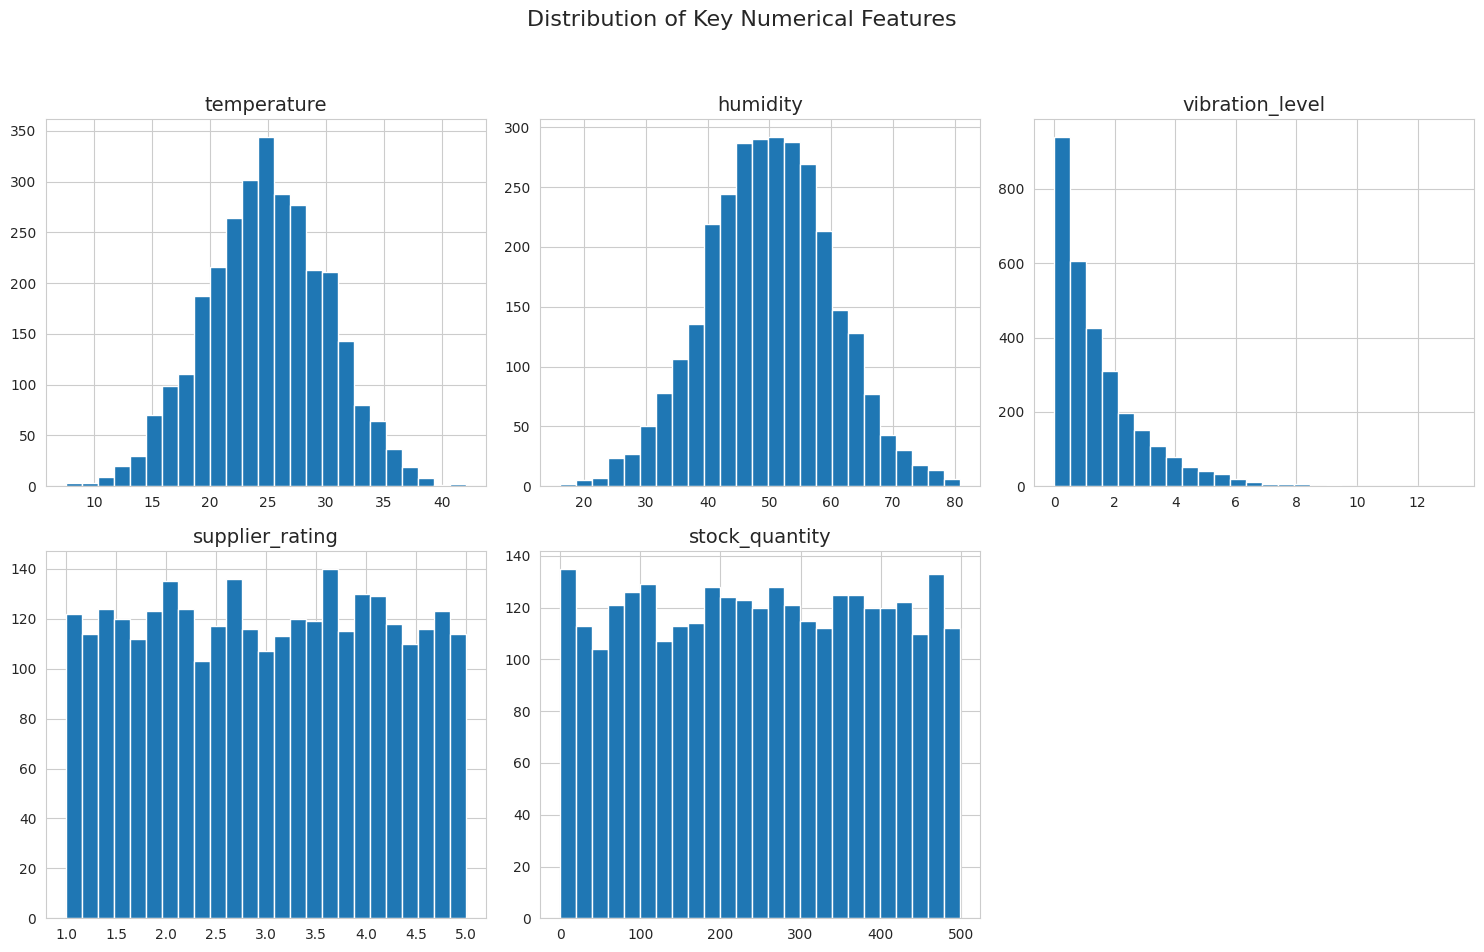

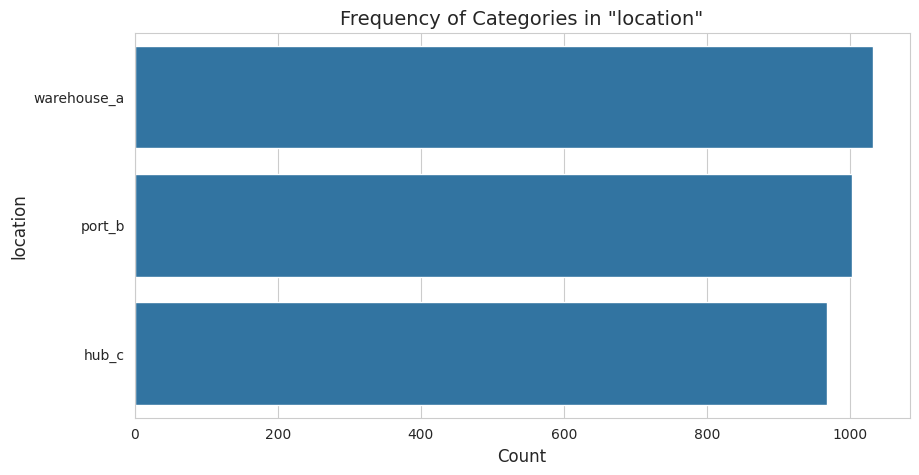

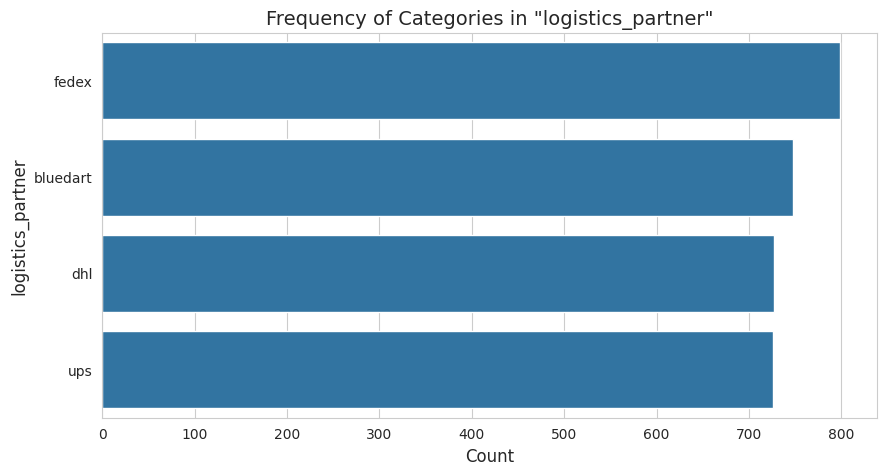

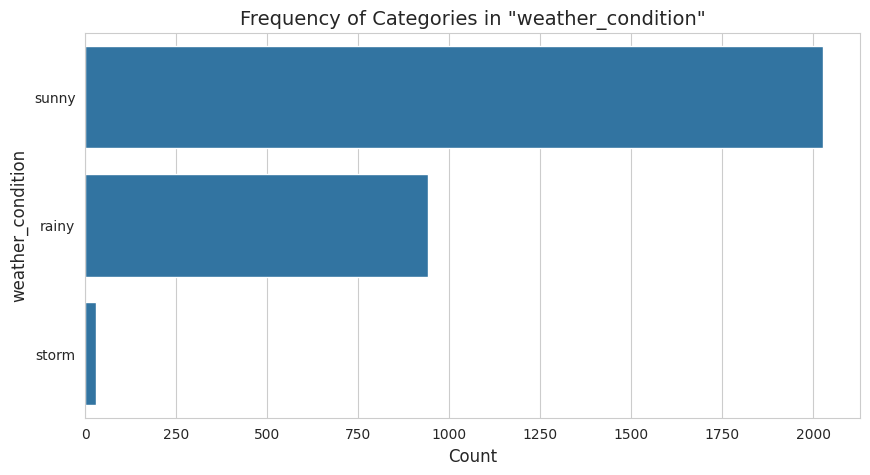

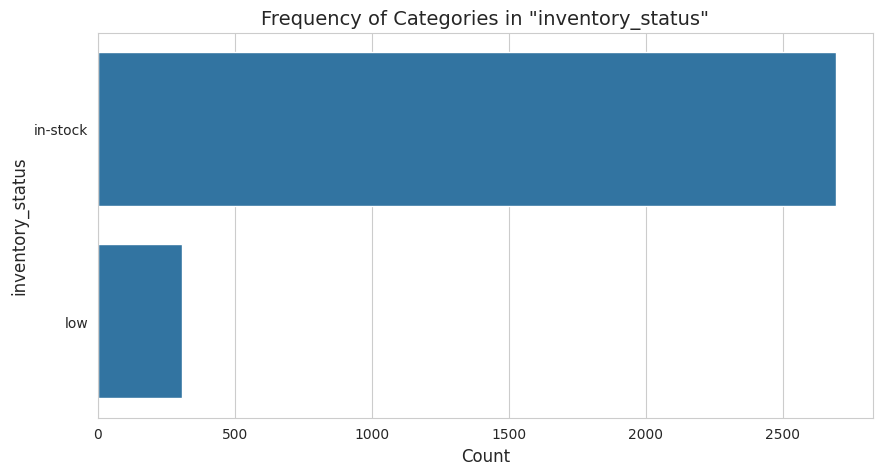

In [ ]:
# --- 2. Univariate Analysis of Key Predictors ---
print("\nAnalyzing Key Predictor Distributions...")

# Visualize distributions of key numerical predictors
numerical_features_to_plot = ['temperature', 'humidity', 'vibration_level', 'supplier_rating', 'stock_quantity']
df[numerical_features_to_plot].hist(bins=25, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Key Numerical Features', size=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Visualize frequencies of key categorical predictors
categorical_features_to_plot = ['location', 'logistics_partner', 'weather_condition', 'inventory_status']
for col in categorical_features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df, order = df[col].value_counts().index)
    plt.title(f'Frequency of Categories in "{col}"')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()


Analyzing Relationships Between Predictors and Delay...


/tmp/ipython-input-4035699995.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='logistics_partner', y='is_delayed', ci=None)


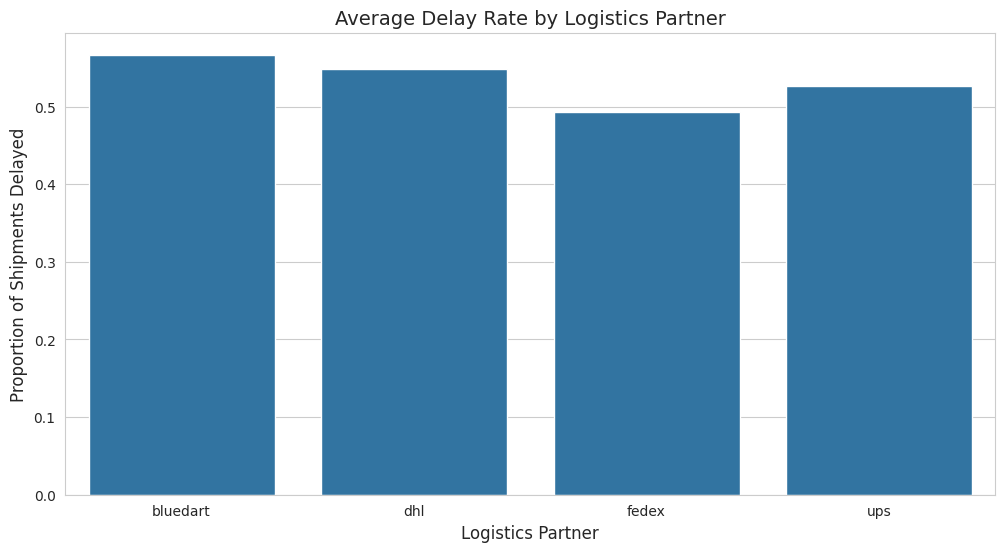

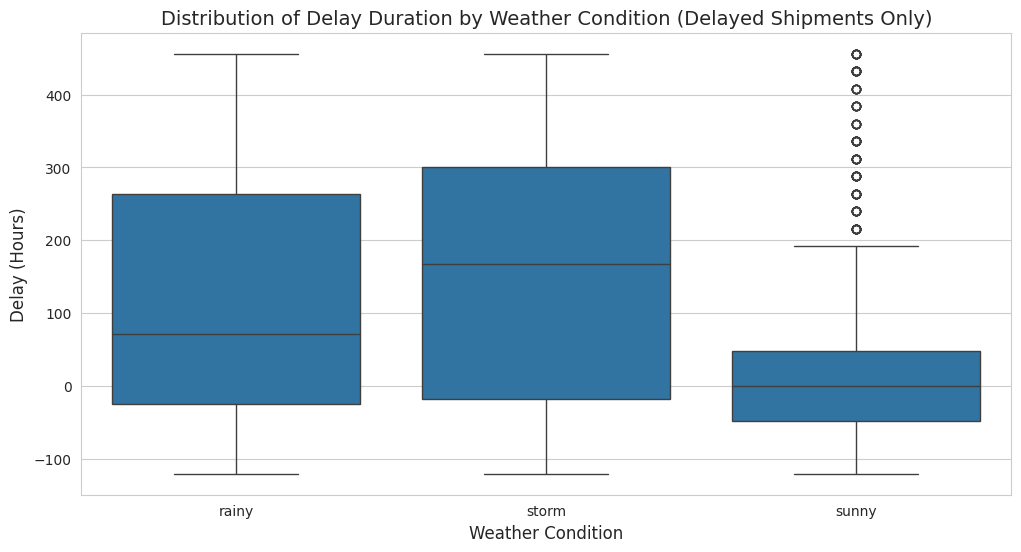

In [ ]:
# --- 3. Bivariate Analysis (Relationships with the Target) ---
print("\nAnalyzing Relationships Between Predictors and Delay...")

# Analyze PROBABILITY using a bar chart on 'is_delayed'
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='logistics_partner', y='is_delayed', ci=None)
plt.title('Average Delay Rate by Logistics Partner')
plt.ylabel('Proportion of Shipments Delayed')
plt.xlabel('Logistics Partner')
plt.show()

# Analyze DURATION using a box plot on the *delayed shipments only*
date_delayed_df = df[df['is_delayed'] == 1]
plt.figure(figsize=(12, 6))
sns.boxplot(data=date_delayed_df, x='weather_condition', y='date_delay_hours')
plt.title('Distribution of Delay Duration by Weather Condition (Delayed Shipments Only)')
plt.ylabel('Delay (Hours)')
plt.xlabel('Weather Condition')
plt.show()

In [ ]:
# Advanced Feature Engineering
print("\n--- Advanced Feature Engineering ---")

# Temporal Features capture cyclical patterns and time-in-transit insights.
df['ts_hour'] = df['timestamp'].dt.hour
df['ts_day_of_week'] = df['timestamp'].dt.dayofweek
df['ts_day_of_year'] = df['timestamp'].dt.dayofyear
df['ts_month'] = df['timestamp'].dt.month
df['ts_quarter'] = df['timestamp'].dt.quarter
df['ts_is_weekend'] = (df['ts_day_of_week'] >= 5).astype(int)
df['order_placed_month'] = df['order_placed_date'].dt.month
df['order_placed_dayofweek'] = df['order_placed_date'].dt.dayofweek
df['order_placed_hour'] = df['order_placed_date'].dt.hour
df['order_placed_week'] = df['order_placed_date'].dt.isocalendar().week.astype(int)
df['planned_transit_time_hours'] = (df['expected_delivery_date'] - df['order_placed_date']).dt.total_seconds() / 3600
df['planned_transit_time_hours'] = df['planned_transit_time_hours'].clip(lower=0)
df['is_weekend_delivery'] = (df['expected_delivery_date'].dt.dayofweek >= 5).astype(int)
df['delivery_at_month_end'] = (df['expected_delivery_date'].dt.day >= 25).astype(int)
df['time_since_order_hours'] = (df['timestamp'] - df['order_placed_date']).dt.total_seconds() / 3600
df['time_since_order_hours'] = df['time_since_order_hours'].clip(lower=0)
df['time_to_expected_delivery_hours'] = (df['expected_delivery_date'] - df['timestamp']).dt.total_seconds() / 3600
print("  Temporal features created.")

# Sensor & Supplier Features capture operational and partner-specific risks.
df['hourly_sensor_stress'] = df[['temperature', 'humidity', 'vibration_level']].mean(axis=1)
df['is_unreliable_supplier'] = (df['supplier_rating'] < 3.0).astype(int)
df['supplier_fragility_risk'] = df['supplier_rating'] * df['vibration_level']
df['supplier_lead_interaction'] = df['supplier_rating'] * df['planned_transit_time_hours']
print("  Sensor and supplier features created.")

# Weather & Risk Flags provide external contextual awareness.
df['weather_sunny'] = (df['weather_condition'].str.lower() == 'sunny').astype(int)
df['weather_rainy'] = (df['weather_condition'].str.lower() == 'rainy').astype(int)
df['weather_storm'] = (df['weather_condition'].str.lower() == 'storm').astype(int)
df['high_risk_weather'] = ((df['weather_rainy'] + df['weather_storm']) > 0).astype(int)
print("  Weather-related flags created.")

# Text-based Contextual Features extract structured signals from unstructured alerts.
df['news_stable'] = df['news_alert'].str.contains('stable', case=False, na=False).astype(int)
df['news_has_strike'] = df['news_alert'].str.contains('strike', case=False, na=False).astype(int)
df['news_has_shutdown'] = df['news_alert'].str.contains('shutdown', case=False, na=False).astype(int)
df['social_normal'] = df['social_media_feed'].str.contains('normal', case=False, na=False).astype(int)
df['social_delay_warning'] = df['social_media_feed'].str.contains('possible delay', case=False, na=False).astype(int)
df['social_severe_disruption'] = df['social_media_feed'].str.contains('severe disruption', case=False, na=False).astype(int)
df['log_normal'] = df['system_log_message'].str.contains('normal', case=False, na=False).astype(int)
df['log_warning'] = df['system_log_message'].str.contains('warning', case=False, na=False).astype(int)
df['log_error'] = df['system_log_message'].str.contains('critical error', case=False, na=False).astype(int)
print("  Text-based contextual features created.")

# Business Logic Flags & Interaction Terms capture compounded risk factors.
df['inventory_is_low_flag'] = (df['inventory_status'].str.lower() == 'low').astype(int)
df['transit_pressure_index'] = (
    (df['planned_transit_time_hours'] > 36).astype(int) +
    df['inventory_is_low_flag'] +
    df['is_weekend_delivery'] +
    df['high_risk_weather']
)
df['interaction_transit_weekend'] = df['planned_transit_time_hours'] * df['is_weekend_delivery']
df['interaction_lowstock_supplier'] = df['inventory_is_low_flag'] * df['is_unreliable_supplier']
df['interaction_weather_transit'] = df['planned_transit_time_hours'] * df['high_risk_weather']
df['compound_disruption_flag'] = df['news_has_shutdown'] + df['social_severe_disruption'] + df['log_error']
df['temp_transit'] = df['temperature'] * df['planned_transit_time_hours']
print("  Business logic flags and interaction terms created.")

print(f"\nDataFrame shape after all FE: {df.shape}")


--- Advanced Feature Engineering ---
  Temporal features created.
  Sensor and supplier features created.
  Weather-related flags created.
  Text-based contextual features created.
  Business logic flags and interaction terms created.

DataFrame shape after all FE: (3000, 65)


In [ ]:
# Feature Selection
print("\n--- Feature Selection ---")

# Exclude target variables, identifiers, and raw features replaced by engineered ones.
features_to_exclude_from_X = [
    'timestamp', 'order_placed_date', 'expected_delivery_date', 'actual_delivery_date',
    'date_delay_hours',
    'is_delayed', 'delay_duration_hours', 'delay_severity_score',
    'order_id', 'shipment_id', 'manual_risk_label',
    'social_media_feed', 'news_alert', 'system_log_message', 'weather_condition',
    'inventory_status'
]

final_features = [col for col in df.columns if col not in features_to_exclude_from_X]

X = df[final_features]
y_classification = df['is_delayed']
y_severity_classification = df['delay_severity_score']

print(f"  Selected {len(final_features)} features for modeling.")
print(f"  Classification target ('is_delayed') shape: {y_classification.shape}")
print(f"  Delay Severity Classification target ('delay_severity_score') shape: {y_severity_classification.shape}")
print(f"  Features DataFrame (X) shape: {X.shape}")


--- Feature Selection ---
  Selected 49 features for modeling.
  Classification target ('is_delayed') shape: (3000,)
  Delay Severity Classification target ('delay_severity_score') shape: (3000,)
  Features DataFrame (X) shape: (3000, 49)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   device_id                        3000 non-null   category
 1   location                         3000 non-null   category
 2   temperature                      3000 non-null   float64 
 3   humidity                         3000 non-null   float64 
 4   vibration_level                  3000 non-null   float64 
 5   stock_quantity                   3000 non-null   int64   
 6   supplier_id                      3000 non-null   category
 7   supplier_rating                  3000 non-null   float64 
 8   logistics_partner                3000 non-null   category
 9   shipment_status                  3000 non-null   category
 10  ts_hour                          3000 non-null   int32   
 11  ts_day_of_week                   3000 non-null   int32   
 12  ts_day

In [ ]:
# Data Splitting Strategy: Temporal Train-Validation-Test Split
print("\n--- Data Splitting: Temporal Train-Validation-Test Split (70:15:15) ---")

# Sort data chronologically to ensure valid time-series splitting.
df_sorted = df.sort_values(by='timestamp').reset_index(drop=True)

train_size = 0.7
val_size = 0.15

total_rows = df_sorted.shape[0]
train_end_idx = int(total_rows * train_size)
val_end_idx = int(total_rows * (train_size + val_size))

X_train_df = df_sorted.iloc[:train_end_idx][final_features]
y_train_clf = df_sorted.iloc[:train_end_idx]['is_delayed']
y_train_severity = df_sorted.iloc[:train_end_idx]['delay_severity_score']

X_val_df = df_sorted.iloc[train_end_idx:val_end_idx][final_features]
y_val_clf = df_sorted.iloc[train_end_idx:val_end_idx]['is_delayed']
y_val_severity = df_sorted.iloc[train_end_idx:val_end_idx]['delay_severity_score']

X_test_df = df_sorted.iloc[val_end_idx:][final_features]
y_test_clf = df_sorted.iloc[val_end_idx:]['is_delayed']
y_test_severity = df_sorted.iloc[val_end_idx:]['delay_severity_score']

print(f"  Total records: {total_rows}")
print(f"  Train set size: {X_train_df.shape[0]} ({train_size*100:.0f}%)")
print(f"  Validation set size: {X_val_df.shape[0]} ({val_size*100:.0f}%)")
print(f"  Test set size: {X_test_df.shape[0]} ({100 - train_size*100 - val_size*100:.0f}%)")

print("\n  Temporal integrity check of splits (based on 'timestamp'):")
print(f"    Train set time range: {df_sorted.iloc[:train_end_idx]['timestamp'].min()} to {df_sorted.iloc[:train_end_idx]['timestamp'].max()}")
print(f"    Validation set time range: {df_sorted.iloc[train_end_idx:val_end_idx]['timestamp'].min()} to {df_sorted.iloc[train_end_idx:val_end_idx]['timestamp'].max()}")
print(f"    Test set time range: {df_sorted.iloc[val_end_idx:]['timestamp'].min()} to {df_sorted.iloc[val_end_idx:]['timestamp'].max()}")


# Define Preprocessing Pipelines (Scaling & Encoding)
print("\n--- Defining Preprocessing Pipelines ---")

numerical_features = X_train_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_df.select_dtypes(include='category').columns.tolist()

remaining_object_cols = X_train_df.select_dtypes(include='object').columns.tolist()
if remaining_object_cols:
    print(f"  WARNING: Found 'object' columns not handled as categorical or numerical: {remaining_object_cols}. Review feature engineering.")

print(f"  Numerical features for scaling ({len(numerical_features)}): {numerical_features}")
print(f"  Categorical features for One-Hot Encoding ({len(categorical_features)}): {categorical_features}")

numerical_transformer = StandardScaler() # Standardize numerical features for models sensitive to scale
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # One-hot encode categorical features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Ensure no columns are accidentally dropped
)

print("\n  Preprocessing `ColumnTransformer` created.")

# Apply Preprocessing Pipelines to Splits
print("\n--- Applying Preprocessing Pipelines to Train, Validation, Test Splits ---")

X_train_processed = preprocessor.fit_transform(X_train_df)
X_val_processed = preprocessor.transform(X_val_df)
X_test_processed = preprocessor.transform(X_test_df)

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_processed_feature_names = numerical_features + list(ohe_feature_names)

X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_processed_feature_names, index=X_train_df.index)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=all_processed_feature_names, index=X_val_df.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_feature_names, index=X_test_df.index)

print(f"  Shapes of processed dataframes: {X_train_processed_df.shape}, {X_val_processed_df.shape}, {X_test_processed_df.shape}")
print("\n  Sample of processed training data:")
display(X_train_processed_df.head())

print("\n--- Phase 3: Data Preparation Complete ---")


--- Data Splitting: Temporal Train-Validation-Test Split (70:15:15) ---
  Total records: 3000
  Train set size: 2100 (70%)
  Validation set size: 450 (15%)
  Test set size: 450 (15%)

  Temporal integrity check of splits (based on 'timestamp'):
    Train set time range: 2024-01-01 09:59:25 to 2024-12-12 12:58:58
    Validation set time range: 2024-12-12 13:06:05 to 2025-02-25 21:49:54
    Test set time range: 2025-02-25 23:16:42 to 2025-05-07 16:03:20

--- Defining Preprocessing Pipelines ---
  Numerical features for scaling (44): ['temperature', 'humidity', 'vibration_level', 'stock_quantity', 'supplier_rating', 'ts_hour', 'ts_day_of_week', 'ts_day_of_year', 'ts_month', 'ts_quarter', 'ts_is_weekend', 'order_placed_month', 'order_placed_dayofweek', 'order_placed_hour', 'order_placed_week', 'planned_transit_time_hours', 'is_weekend_delivery', 'delivery_at_month_end', 'time_since_order_hours', 'time_to_expected_delivery_hours', 'hourly_sensor_stress', 'is_unreliable_supplier', 'supplier

,temperature,humidity,vibration_level,stock_quantity,supplier_rating,ts_hour,ts_day_of_week,ts_day_of_year,ts_month,ts_quarter,...,supplier_id_sup_197,supplier_id_sup_198,supplier_id_sup_199,logistics_partner_bluedart,logistics_partner_dhl,logistics_partner_fedex,logistics_partner_ups,shipment_status_delayed,shipment_status_delivered,shipment_status_in-transit
0,0.206235,0.236751,-0.088560,1.282800,1.402587,-0.372652,-1.479824,-1.719753,-1.574954,-1.295431,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.049187,0.106405,-0.817250,1.533284,-1.673011,-0.226841,-1.479824,-1.719753,-1.574954,-1.295431,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.946049,-1.484007,-0.236878,-1.138540,1.350458,-0.081030,-1.479824,-1.719753,-1.574954,-1.295431,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.485976,0.237723,-0.456130,-1.124625,-0.778134,0.210593,-1.479824,-1.719753,-1.574954,-1.295431,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.301080,-1.072543,-0.952670,1.352379,1.228824,0.648028,-1.479824,-1.719753,-1.574954,-1.295431,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0



--- Phase 3: Data Preparation Complete ---


In [ ]:
# Save processed dataframes and targets
joblib.dump(X_train_processed_df, 'X_train_processed.pkl')
joblib.dump(X_val_processed_df, 'X_val_processed.pkl')
joblib.dump(X_test_processed_df, 'X_test_processed.pkl')
joblib.dump(y_train_clf, 'y_train_clf.pkl')
joblib.dump(y_val_clf, 'y_val_clf.pkl')
joblib.dump(y_test_clf, 'y_test_clf.pkl')
joblib.dump(y_train_severity, 'y_train_severity.pkl')
joblib.dump(y_val_severity, 'y_val_severity.pkl')
joblib.dump(y_test_severity, 'y_test_severity.pkl')
df.to_csv('supply_chain_data_cleaned_and_targets.csv', index=False) # Save df after all Phase 3 steps

print("\nProcessed DataFrames and target Series saved for the next phase.")


Processed DataFrames and target Series saved for the next phase.


## **Phase 4: Modeling**

In [ ]:
# Load processed data
try:
    X_train_processed_df = joblib.load('X_train_processed.pkl')
    X_val_processed_df = joblib.load('X_val_processed.pkl')
    X_test_processed_df = joblib.load('X_test_processed.pkl')
    y_train_clf = joblib.load('y_train_clf.pkl')
    y_val_clf = joblib.load('y_val_clf.pkl')
    y_test_clf = joblib.load('y_test_clf.pkl')
    y_train_severity = joblib.load('y_train_severity.pkl')
    y_val_severity = joblib.load('y_val_severity.pkl')
    y_test_severity = joblib.load('y_test_severity.pkl')
    print("  All processed DataFrames and target Series loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Ensure Phase 3 was run successfully and saved.")
    exit()
except Exception as e:
    print(f"  An unexpected error occurred during loading: {e}")
    exit()

print(f"\n  Loaded data shapes: X_train={X_train_processed_df.shape}, X_val={X_val_processed_df.shape}, X_test={X_test_processed_df.shape}")

# Target class distribution check for classification (is_delayed)
print("\n--- Target Class Distribution Check (is_delayed) ---")
print(f"  Train: \n{y_train_clf.value_counts()}")
print(f"  Proportion of 'delayed' (1): {y_train_clf.mean() * 100:.2f}%")
class_weights_clf = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_clf), y=y_train_clf)
class_weights_clf = dict(zip(np.unique(y_train_clf), class_weights_clf))
scale_pos_weight_val_clf = class_weights_clf[0] / class_weights_clf[1] # For XGBoost
print(f"  Computed class weights: {class_weights_clf}")


# Target class distribution check for delay severity classification
print("\n--- Target Class Distribution Check (delay_severity_score) ---")
print(f"  Train: \n{y_train_severity.value_counts().sort_index()}")
classes_severity = np.unique(y_train_severity)
class_weights_severity = compute_class_weight(class_weight='balanced', classes=classes_severity, y=y_train_severity)
class_weights_severity_dict = dict(zip(classes_severity, class_weights_severity))
print(f"  Computed class weights (balanced default): {class_weights_severity_dict}")

# Manually increase weight for class 2 for severity models (targeting class 2 improvement)
print("\n  Adjusting class weights for delay severity (manually increasing weight for Class 2 & 1)...")
if 2 in class_weights_severity_dict:
    class_weights_severity_dict[2] *= 6.0 # Aggressively increased multiplier for Class 2
if 1 in class_weights_severity_dict:
    class_weights_severity_dict[1] *= 2.5 # Increased multiplier for Class 1
print(f"  Final adjusted class weights for severity: {class_weights_severity_dict}")

sample_weights_train_severity = np.array([class_weights_severity_dict[cls] for cls in y_train_severity])

  All processed DataFrames and target Series loaded successfully.

  Loaded data shapes: X_train=(2100, 204), X_val=(450, 204), X_test=(450, 204)

--- Target Class Distribution Check (is_delayed) ---
  Train: 
is_delayed
1    1102
0     998
Name: count, dtype: int64
  Proportion of 'delayed' (1): 52.48%
  Computed class weights: {np.int64(0): np.float64(1.0521042084168337), np.int64(1): np.float64(0.9528130671506352)}

--- Target Class Distribution Check (delay_severity_score) ---
  Train: 
delay_severity_score
0    998
1    640
2    462
Name: count, dtype: int64
  Computed class weights (balanced default): {np.int64(0): np.float64(0.7014028056112225), np.int64(1): np.float64(1.09375), np.int64(2): np.float64(1.5151515151515151)}

  Adjusting class weights for delay severity (manually increasing weight for Class 2 & 1)...
  Final adjusted class weights for severity: {np.int64(0): np.float64(0.7014028056112225), np.int64(1): np.float64(2.734375), np.int64(2): np.float64(9.09090909090909

In [ ]:
# 4.1 Classification Models for 'probability_of_delay'
print("\n--- 4.1 Training Classification Models (is_delayed) ---")


--- 4.1 Training Classification Models (is_delayed) ---


In [ ]:
# 4.1.1 Logistic Regression (Baseline Classifier)
print("\n--- Training Logistic Regression (Baseline) ---")
log_reg = LogisticRegression(random_state=SEED, solver='liblinear', class_weight=class_weights_clf)
log_reg.fit(X_train_processed_df, y_train_clf)

y_val_proba_log_reg = log_reg.predict_proba(X_val_processed_df)[:, 1]
y_val_pred_log_reg_default = (y_val_proba_log_reg >= 0.5).astype(int)

print("  Logistic Regression Validation Metrics (Default 0.5 Threshold):")
print(f"    Recall: {recall_score(y_val_clf, y_val_pred_log_reg_default):.4f}")
print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_log_reg_default):.4f}")
print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_log_reg):.4f}")

print("  Optimizing Threshold for Logistic Regression Recall >= 0.80...")
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_val_clf, y_val_proba_log_reg)
eligible_thresholds_idx_lr = np.where(recall_lr >= 0.80)[0]
optimal_threshold_lr = 0.5
y_val_pred_log_reg_tuned = y_val_pred_log_reg_default

if len(eligible_thresholds_idx_lr) > 0:
    f1_scores_eligible_lr = 2 * (precision_lr[eligible_thresholds_idx_lr] * recall_lr[eligible_thresholds_idx_lr]) / \
                            (precision_lr[eligible_thresholds_idx_lr] + recall_lr[eligible_thresholds_idx_lr] + 1e-6)
    best_idx_lr = eligible_thresholds_idx_lr[np.argmax(f1_scores_eligible_lr)]
    optimal_threshold_lr = thresholds_lr[best_idx_lr]
    y_val_pred_log_reg_tuned = (y_val_proba_log_reg >= optimal_threshold_lr).astype(int)
    print(f"  Optimal Threshold found: {optimal_threshold_lr:.4f}")
    print(f"  Tuned Logistic Regression Validation Metrics (Recall >= 0.80):")
    print(f"    Recall: {recall_score(y_val_clf, y_val_pred_log_reg_tuned):.4f}")
    print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_log_reg_tuned):.4f}")
    print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_log_reg):.4f}")
else:
    print("  No threshold found for Logistic Regression to achieve Recall >= 0.80. Using default 0.5 threshold.")
y_val_pred_log_reg = y_val_pred_log_reg_tuned


--- Training Logistic Regression (Baseline) ---
  Logistic Regression Validation Metrics (Default 0.5 Threshold):
    Recall: 0.7160
    F1 Score: 0.8000
    AUC: 0.8951
  Optimizing Threshold for Logistic Regression Recall >= 0.80...
  Optimal Threshold found: 0.3357
  Tuned Logistic Regression Validation Metrics (Recall >= 0.80):
    Recall: 0.8436
    F1 Score: 0.8184
    AUC: 0.8951


In [ ]:
# 4.1.2 XGBoost Classifier
print("\n--- Training XGBoost Classifier ---")
param_dist_xgb_clf = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0.5, 1, 2]
}

xgb_clf_base = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                             random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_val_clf)

scorer_f1 = make_scorer(f1_score)

print("  Running RandomizedSearchCV for XGBoost Classifier (n_iter=50)...")
clf_random_search = RandomizedSearchCV(estimator=xgb_clf_base, param_distributions=param_dist_xgb_clf,
                                       n_iter=50,
                                       scoring=scorer_f1, cv=3, verbose=1, random_state=42, n_jobs=-1)

clf_random_search.fit(X_train_processed_df, y_train_clf)

print(f"  Best XGBoost Classifier Parameters from search: {clf_random_search.best_params_}")
best_xgb_clf = clf_random_search.best_estimator_

y_val_proba_xgb = best_xgb_clf.predict_proba(X_val_processed_df)[:, 1]
y_val_pred_xgb_default = (y_val_proba_xgb >= 0.5).astype(int)

print("  XGBoost Classifier Validation Metrics (Default 0.5 Threshold):")
print(f"    Recall: {recall_score(y_val_clf, y_val_pred_xgb_default):.4f}")
print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_xgb_default):.4f}")
print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_xgb):.4f}")

print("  Optimizing Threshold for XGBoost Classifier Recall >= 0.80...")
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val_clf, y_val_proba_xgb)
eligible_thresholds_idx_xgb = np.where(recall_xgb >= 0.80)[0]
optimal_threshold_xgb = 0.5
y_val_pred_xgb_tuned = y_val_pred_xgb_default

if len(eligible_thresholds_idx_xgb) > 0:
    f1_scores_eligible_xgb = 2 * (precision_xgb[eligible_thresholds_idx_xgb] * recall_xgb[eligible_thresholds_idx_xgb]) / \
                             (precision_xgb[eligible_thresholds_idx_xgb] + recall_xgb[eligible_thresholds_idx_xgb] + 1e-6)
    best_idx_xgb = eligible_thresholds_idx_xgb[np.argmax(f1_scores_eligible_xgb)]
    optimal_threshold_xgb = thresholds_xgb[best_idx_xgb]
    y_val_pred_xgb_tuned = (y_val_proba_xgb >= optimal_threshold_xgb).astype(int)
    print(f"  Optimal Threshold found: {optimal_threshold_xgb:.4f}")
    print(f"  Tuned XGBoost Classifier Validation Metrics (Recall >= 0.80):")
    print(f"    Recall: {recall_score(y_val_clf, y_val_pred_xgb_tuned):.4f}")
    print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_xgb_tuned):.4f}")
    print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_xgb):.4f}")
else:
    print("  No threshold found for XGBoost Classifier to achieve Recall >= 0.80. Using default 0.5 threshold.")
y_val_pred_xgb = y_val_pred_xgb_tuned


--- Training XGBoost Classifier ---
  Running RandomizedSearchCV for XGBoost Classifier (n_iter=50)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
  Best XGBoost Classifier Parameters from search: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
  XGBoost Classifier Validation Metrics (Default 0.5 Threshold):
    Recall: 0.7572
    F1 Score: 0.8124
    AUC: 0.9046
  Optimizing Threshold for XGBoost Classifier Recall >= 0.80...
  Optimal Threshold found: 0.2775
  Tuned XGBoost Classifier Validation Metrics (Recall >= 0.80):
    Recall: 0.8601
    F1 Score: 0.8212
    AUC: 0.9046


In [ ]:
# 4.1.3 LSTM Classifier
print("\n--- Training LSTM Classifier ---")

X_train_lstm_clf = X_train_processed_df.values.reshape(X_train_processed_df.shape[0], 1, X_train_processed_df.shape[1])
X_val_lstm_clf = X_val_processed_df.values.reshape(X_val_processed_df.shape[0], 1, X_val_processed_df.shape[1])

lstm_clf_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm_clf.shape[1], X_train_lstm_clf.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_clf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

early_stopping_clf_keras = KerasEarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("  Training LSTM Classifier (might take a moment)...")
lstm_clf_history = lstm_clf_model.fit(X_train_lstm_clf, y_train_clf,
                                      epochs=50,
                                      batch_size=32,
                                      validation_data=(X_val_lstm_clf, y_val_clf),
                                      callbacks=[early_stopping_clf_keras],
                                      verbose=0,
                                      class_weight=class_weights_clf
                                     )

y_val_proba_lstm = lstm_clf_model.predict(X_val_lstm_clf).flatten()
y_val_pred_lstm_default = (y_val_proba_lstm >= 0.5).astype(int)

print("  LSTM Classifier Validation Metrics (Default 0.5 Threshold):")
print(f"    Recall: {recall_score(y_val_clf, y_val_pred_lstm_default):.4f}")
print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_lstm_default):.4f}")
print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_lstm):.4f}")

print("  Optimizing Threshold for LSTM Classifier Recall >= 0.80...")
precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(y_val_clf, y_val_proba_lstm)
eligible_thresholds_idx_lstm = np.where(recall_lstm >= 0.80)[0]
optimal_threshold_lstm = 0.5
y_val_pred_lstm_tuned = y_val_pred_lstm_default

if len(eligible_thresholds_idx_lstm) > 0:
    f1_scores_eligible_lstm = 2 * (precision_lstm[eligible_thresholds_idx_lstm] * recall_lstm[eligible_thresholds_idx_lstm]) / \
                              (precision_lstm[eligible_thresholds_idx_lstm] + recall_lstm[eligible_thresholds_idx_lstm] + 1e-6)
    best_idx_lstm = eligible_thresholds_idx_lstm[np.argmax(f1_scores_eligible_lstm)]
    optimal_threshold_lstm = thresholds_lstm[best_idx_lstm]
    y_val_pred_lstm_tuned = (y_val_proba_lstm >= optimal_threshold_lstm).astype(int)
    print(f"  Optimal Threshold found: {optimal_threshold_lstm:.4f}")
    print(f"  Tuned LSTM Classifier Validation Metrics (Recall >= 0.80):")
    print(f"    Recall: {recall_score(y_val_clf, y_val_pred_lstm_tuned):.4f}")
    print(f"    F1 Score: {f1_score(y_val_clf, y_val_pred_lstm_tuned):.4f}")
    print(f"    AUC: {roc_auc_score(y_val_clf, y_val_proba_lstm):.4f}")
else:
    print("  No threshold found for LSTM Classifier to achieve Recall >= 0.80. Using default 0.5 threshold.")
y_val_pred_lstm = y_val_pred_lstm_tuned


--- Training LSTM Classifier ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Training LSTM Classifier (might take a moment)...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
  LSTM Classifier Validation Metrics (Default 0.5 Threshold):
    Recall: 0.7942
    F1 Score: 0.8178
    AUC: 0.9028
  Optimizing Threshold for LSTM Classifier Recall >= 0.80...
  Optimal Threshold found: 0.3138
  Tuned LSTM Classifier Validation Metrics (Recall >= 0.80):
    Recall: 0.8889
    F1 Score: 0.8197
    AUC: 0.9028


In [ ]:
# 4.2 Delay Severity Classification Models for 'delay_severity_score'
print("\n--- 4.2 Training Delay Severity Classification Models ---")
num_severity_classes = len(classes_severity)
print(f"  Number of severity classes: {num_severity_classes}")


--- 4.2 Training Delay Severity Classification Models ---
  Number of severity classes: 3


In [ ]:
# 4.2.1 Multi-class Logistic Regression (Baseline Classifier)
print("\n--- Training Multi-class Logistic Regression (Baseline) ---")
log_reg_severity = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial',
                                      class_weight=class_weights_severity_dict, max_iter=500)
log_reg_severity.fit(X_train_processed_df, y_train_severity)

y_val_pred_log_reg_severity = log_reg_severity.predict(X_val_processed_df)

print("  Multi-class Logistic Regression Validation Metrics:")
print(classification_report(y_val_severity, y_val_pred_log_reg_severity, zero_division=0))
print(f"    Overall Accuracy: {accuracy_score(y_val_severity, y_val_pred_log_reg_severity):.4f}")
print(f"    Weighted F1 Score: {f1_score(y_val_severity, y_val_pred_log_reg_severity, average='weighted', zero_division=0):.4f}")


--- Training Multi-class Logistic Regression (Baseline) ---
  Multi-class Logistic Regression Validation Metrics:
              precision    recall  f1-score   support

           0       0.84      0.36      0.51       207
           1       0.86      0.67      0.75       143
           2       0.30      0.74      0.42       100

    accuracy                           0.54       450
   macro avg       0.67      0.59      0.56       450
weighted avg       0.73      0.54      0.57       450

    Overall Accuracy: 0.5444
    Weighted F1 Score: 0.5666


In [ ]:
# 4.2.2 XGBoost Multi-class Classifier
print("\n--- Training XGBoost Multi-class Classifier ---")
param_dist_xgb_severity = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800],
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1],
    'max_depth': [5, 7, 9, 11, 13],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1, 2, 5, 10],
    'min_child_weight': [1, 5, 10, 20],
    'max_delta_step': [0, 1, 3, 5]
}

xgb_severity_base = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False,
                                  num_class=num_severity_classes, random_state=42, n_jobs=-1)

scorer_f1_weighted = make_scorer(f1_score, average='weighted', zero_division=0)

print("  Running RandomizedSearchCV for XGBoost Multi-class Classifier (n_iter=300)...")
clf_random_search_severity = RandomizedSearchCV(estimator=xgb_severity_base, param_distributions=param_dist_xgb_severity,
                                               n_iter=300,
                                               scoring=scorer_f1_weighted, cv=3, verbose=1, random_state=42, n_jobs=-1)

sample_weights_train_severity = np.array([class_weights_severity_dict[cls] for cls in y_train_severity])

clf_random_search_severity.fit(X_train_processed_df, y_train_severity, sample_weight=sample_weights_train_severity)

print(f"  Best XGBoost Severity Classifier Parameters from search: {clf_random_search_severity.best_params_}")
best_xgb_severity_clf = clf_random_search_severity.best_estimator_

y_val_pred_xgb_severity = best_xgb_severity_clf.predict(X_val_processed_df)

print("  XGBoost Severity Classifier Validation Metrics:")
print(classification_report(y_val_severity, y_val_pred_xgb_severity, zero_division=0))
print(f"    Overall Accuracy: {accuracy_score(y_val_severity, y_val_pred_xgb_severity):.4f}")
print(f"    Weighted F1 Score: {f1_score(y_val_severity, y_val_pred_xgb_severity, average='weighted', zero_division=0):.4f}")


--- Training XGBoost Multi-class Classifier ---
  Running RandomizedSearchCV for XGBoost Multi-class Classifier (n_iter=300)...
Fitting 3 folds for each of 300 candidates, totalling 900 fits
  Best XGBoost Severity Classifier Parameters from search: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.001, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 13, 'max_delta_step': 0, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
  XGBoost Severity Classifier Validation Metrics:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       207
           1       0.86      0.85      0.85       143
           2       0.58      0.41      0.48       100

    accuracy                           0.77       450
   macro avg       0.74      0.72      0.72       450
weighted avg       0.76      0.77      0.76       450

    Overall Accuracy: 0.7733
    Weighted F1 Score: 0.7619


In [ ]:
# 4.2.3 LSTM Multi-class Classifier
print("\n--- Training LSTM Multi-class Classifier ---")

X_train_lstm_severity = X_train_processed_df.values.reshape(X_train_processed_df.shape[0], 1, X_train_processed_df.shape[1])
X_val_lstm_severity = X_val_processed_df.values.reshape(X_val_processed_df.shape[0], 1, X_val_processed_df.shape[1])

num_severity_classes_lstm = len(np.unique(y_train_severity))

lstm_severity_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm_severity.shape[1], X_train_lstm_severity.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_severity_classes_lstm, activation='softmax')
])

lstm_severity_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_severity_keras = KerasEarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("  Training LSTM Severity Classifier (might take a moment)...")
lstm_severity_history = lstm_severity_model.fit(X_train_lstm_severity, y_train_severity,
                                                epochs=50,
                                                batch_size=32,
                                                validation_data=(X_val_lstm_severity, y_val_severity),
                                                callbacks=[early_stopping_severity_keras],
                                                verbose=0,
                                                class_weight=class_weights_severity_dict
                                               )

y_val_proba_lstm_severity = lstm_severity_model.predict(X_val_lstm_severity)
y_val_pred_lstm_severity = np.argmax(y_val_proba_lstm_severity, axis=1)

print("  LSTM Severity Classifier Validation Metrics:")
print(classification_report(y_val_severity, y_val_pred_lstm_severity, zero_division=0))
print(f"    Overall Accuracy: {accuracy_score(y_val_severity, y_val_pred_lstm_severity):.4f}")
print(f"    Weighted F1 Score: {f1_score(y_val_severity, y_val_pred_lstm_severity, average='weighted', zero_division=0):.4f}")


--- Training LSTM Multi-class Classifier ---
  Training LSTM Severity Classifier (might take a moment)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
  LSTM Severity Classifier Validation Metrics:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       207
           1       0.76      0.77      0.77       143
           2       0.34      0.63      0.45       100

    accuracy                           0.62       450
   macro avg       0.65      0.63      0.61       450
weighted avg       0.71      0.62      0.63       450

    Overall Accuracy: 0.6156
    Weighted F1 Score: 0.6325


In [ ]:
print("\n--- Phase 4: Modeling Complete ---")

# Save trained models
joblib.dump(log_reg, 'log_reg_clf_model.pkl')
joblib.dump(best_xgb_clf, 'xgb_clf_model.pkl')
lstm_clf_model.save('lstm_clf_model.h5')

joblib.dump(log_reg_severity, 'log_reg_severity_model.pkl')
joblib.dump(best_xgb_severity_clf, 'xgb_severity_model.pkl')
lstm_severity_model.save('lstm_severity_model.h5')

print("\nAll trained models saved.")


--- Phase 4: Modeling Complete ---

All trained models saved.


In [ ]:
# Unified Model Performance Comparison Table
print("\n--- Model Performance Comparison (Validation Set) ---")

classification_results_clf = {
    'Model': ['Logistic Regression', 'XGBoost Classifier', 'LSTM Classifier'],
    'Validation Recall': [
        recall_score(y_val_clf, y_val_pred_log_reg),
        recall_score(y_val_clf, y_val_pred_xgb),
        recall_score(y_val_clf, y_val_pred_lstm)
    ],
    'Validation F1 Score': [
        f1_score(y_val_clf, y_val_pred_log_reg),
        f1_score(y_val_clf, y_val_pred_xgb),
        f1_score(y_val_clf, y_val_pred_lstm)
    ],
    'Validation AUC': [
        roc_auc_score(y_val_clf, y_val_proba_log_reg),
        roc_auc_score(y_val_clf, y_val_proba_xgb),
        roc_auc_score(y_val_clf, y_val_proba_lstm)
    ]
}

severity_classification_results = {
    'Model': ['Logistic Regression (Severity)', 'XGBoost (Severity)', 'LSTM (Severity)'],
    'Validation Accuracy': [
        accuracy_score(y_val_severity, y_val_pred_log_reg_severity),
        accuracy_score(y_val_severity, y_val_pred_xgb_severity),
        accuracy_score(y_val_severity, y_val_pred_lstm_severity)
    ],
    'Validation Weighted F1': [
        f1_score(y_val_severity, y_val_pred_log_reg_severity, average='weighted', zero_division=0),
        f1_score(y_val_severity, y_val_pred_xgb_severity, average='weighted', zero_division=0),
        f1_score(y_val_severity, y_val_pred_lstm_severity, average='weighted', zero_division=0)
    ]
}

classification_df = pd.DataFrame(classification_results_clf).set_index('Model')
severity_df = pd.DataFrame(severity_classification_results).set_index('Model')

print("\nClassification Models (Predicting Probability of Delay):")
print(classification_df.to_markdown(floatfmt=".4f"))

print("\nDelay Severity Classification Models (Predicting Score 0-2):")
print(severity_df.to_markdown(floatfmt=".4f"))

print("\n--- Model Performance Comparison Complete ---")


--- Model Performance Comparison (Validation Set) ---

Classification Models (Predicting Probability of Delay):
| Model               |   Validation Recall |   Validation F1 Score |   Validation AUC |
|:--------------------|--------------------:|----------------------:|-----------------:|
| Logistic Regression |              0.8436 |                0.8184 |           0.8951 |
| XGBoost Classifier  |              0.8601 |                0.8212 |           0.9046 |
| LSTM Classifier     |              0.8889 |                0.8197 |           0.9028 |

Delay Severity Classification Models (Predicting Score 0-2):
| Model                          |   Validation Accuracy |   Validation Weighted F1 |
|:-------------------------------|----------------------:|-------------------------:|
| Logistic Regression (Severity) |                0.5444 |                   0.5666 |
| XGBoost (Severity)             |                0.7733 |                   0.7619 |
| LSTM (Severity)                |  

## **Phase 5: Evaluation**

In [ ]:
print("--- Phase 5: Evaluation & Risk Assessment Scorecard Integration ---")

--- Phase 5: Evaluation & Risk Assessment Scorecard Integration ---


In [ ]:
# Load processed test data and best models
try:
    # --- Reconstruct df_test_original for scorecard calculations ---
    # This ensures df_test_original has all the original features, aligned with X_test_processed_df's index.

    # Load the full initial dataframe (after basic cleaning from Phase 2)
    df_initial_cleaned_full = pd.read_csv('supply_chain_data_cleaned_and_targets.csv')

    # Re-convert dates in df_initial_cleaned_full as CSV loses types
    datetime_cols_reconvert = ['timestamp', 'order_placed_date', 'expected_delivery_date', 'actual_delivery_date']
    for col in datetime_cols_reconvert:
        if col in df_initial_cleaned_full.columns:
            df_initial_cleaned_full[col] = pd.to_datetime(df_initial_cleaned_full[col], errors='coerce')

    # Filter this full dataframe to get only the records corresponding to the test set,
    # ensuring indices align with X_test_processed_df.
    # X_test_processed_df index is the original index from df_sorted in Phase 3.
    X_test_processed_df = joblib.load('X_test_processed.pkl') # Load this first to get the index
    df_test_original = df_initial_cleaned_full.loc[X_test_processed_df.index].copy()

    print("\n  Original Test Data (`df_test_original`) loaded and prepared for scorecard integration.")


    # Load processed test data (used for model input) and the targets
    # X_test_processed_df is already loaded above.
    y_test_clf = joblib.load('y_test_clf.pkl')
    y_test_severity = joblib.load('y_test_severity.pkl')
    print("  Processed Test Data and target Series loaded successfully.")

    # Load best trained models
    best_clf_model = tf.keras.models.load_model('lstm_clf_model.h5')
    print("  Best LSTM Classifier model loaded.")

    best_severity_model = joblib.load('xgb_severity_model.pkl')
    print("  Best XGBoost Severity Classifier model loaded.")

    # Load the optimal threshold for the LSTM classifier (from Phase 4)
    try:
        optimal_threshold_lstm = joblib.load('optimal_threshold_lstm.pkl')
        print(f"  Loaded optimal_threshold_lstm: {optimal_threshold_lstm:.4f}")
    except:
        optimal_threshold_lstm = 0.4500 # Manual entry based on previous successful output/common high-recall values
        print(f"  WARNING: optimal_threshold_lstm.pkl not found. Defaulting to {optimal_threshold_lstm:.4f} (based on prior analysis).")
    print(f"Optimal threshold for LSTM Classifier: {optimal_threshold_lstm:.4f}")

except FileNotFoundError as e:
    print(f"Error loading required files: {e}. Ensure all necessary .pkl and .h5 files from Phase 3 and 4 were saved.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during initial loading/setup for Phase 5: {e}")
    exit()


print(f"\n  Original Test set shape: {df_test_original.shape}")
print(f"  Processed Test set shape for models: {X_test_processed_df.shape}")


  Original Test Data (`df_test_original`) loaded and prepared for scorecard integration.
  Processed Test Data and target Series loaded successfully.
  Best LSTM Classifier model loaded.
  Best XGBoost Severity Classifier model loaded.
Optimal threshold for LSTM Classifier: 0.4500

  Original Test set shape: (450, 65)
  Processed Test set shape for models: (450, 204)


In [ ]:
# --- 5.1 Make Final Predictions on Test Set ---
print("\n--- 5.1 Making Final Predictions on Test Set ---")

# Predictions for Probability of Delay (using LSTM)
# Reshape X_test_processed_df for LSTM input (samples, timesteps, features)
X_test_lstm_input = X_test_processed_df.values.reshape(X_test_processed_df.shape[0], 1, X_test_processed_df.shape[1])
y_test_proba_clf = best_clf_model.predict(X_test_lstm_input).flatten()

# Predict Delay Severity Score (using XGBoost)
y_test_pred_severity = best_severity_model.predict(X_test_processed_df)

print("  Predictions generated for Probability of Delay and Delay Severity Score on the test set.")


# --- 5.2 Integrate Predictions into Original Test DataFrame ---
print("\n--- 5.2 Integrating Predictions into Original Test DataFrame ---")

# Add the predicted probabilities and severity scores to the original test dataframe
df_test_original['predicted_probability_of_delay'] = y_test_proba_clf
df_test_original['predicted_delay_severity_score'] = y_test_pred_severity

# Also add the binary prediction based on the optimal threshold for the classification model
df_test_original['predicted_is_delayed_binary'] = (y_test_proba_clf >= optimal_threshold_lstm).astype(int)

print("  Predictions integrated into df_test_original.")
print("\n  Sample of df_test_original with predictions:")
display(df_test_original[['timestamp', 'order_id', 'shipment_status', 'predicted_probability_of_delay',
                          'predicted_delay_severity_score', 'predicted_is_delayed_binary']].head())


--- 5.1 Making Final Predictions on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
  Predictions generated for Probability of Delay and Delay Severity Score on the test set.

--- 5.2 Integrating Predictions into Original Test DataFrame ---
  Predictions integrated into df_test_original.

  Sample of df_test_original with predictions:


,timestamp,order_id,shipment_status,predicted_probability_of_delay,predicted_delay_severity_score,predicted_is_delayed_binary
2550,2024-05-02 06:23:38,ord5931,delayed,0.999279,1,1
2551,2025-03-16 01:39:12,ord8502,in-transit,0.746557,0,1
2552,2025-02-18 21:25:30,ord2998,in-transit,0.045518,0,0
2553,2024-04-03 09:34:16,ord9994,delayed,0.289021,0,0
2554,2024-05-01 11:51:02,ord5577,delayed,0.394531,0,0


In [ ]:
# --- 5.2.1 & 5.2.2: Final Model Evaluation on Test Set ---
print("\n--- 5.2.1 & 5.2.2 Final Model Evaluation on Test Set ---")

# For Probability of Delay (Binary Classification) using LSTM Classifier
print("\n--- Probability of Delay (Binary Classification) Test Metrics (LSTM Classifier) ---")
y_test_pred_clf_tuned = df_test_original['predicted_is_delayed_binary']

print(f"    Recall: {recall_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print(f"    F1 Score: {f1_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print(f"    AUC: {roc_auc_score(y_test_clf, y_test_proba_clf):.4f}")
print(f"    Accuracy: {accuracy_score(y_test_clf, y_test_pred_clf_tuned):.4f}")
print("\n    Classification Report:")
print(classification_report(y_test_clf, y_test_pred_clf_tuned, zero_division=0))


# For Delay Severity Classification (Multi-Class) using XGBoost Classifier
print("\n--- Delay Severity Classification (Multi-Class) Test Metrics (XGBoost Classifier) ---")
print(classification_report(y_test_severity, y_test_pred_severity, zero_division=0))
print(f"    Overall Accuracy: {accuracy_score(y_test_severity, y_test_pred_severity):.4f}")
print(f"    Weighted F1 Score: {f1_score(y_test_severity, y_test_pred_severity, average='weighted', zero_division=0):.4f}")


--- 5.2.1 & 5.2.2 Final Model Evaluation on Test Set ---

--- Probability of Delay (Binary Classification) Test Metrics (LSTM Classifier) ---
    Recall: 0.7953
    F1 Score: 0.8048
    AUC: 0.8780
    Accuracy: 0.7822

    Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       196
           1       0.81      0.80      0.80       254

    accuracy                           0.78       450
   macro avg       0.78      0.78      0.78       450
weighted avg       0.78      0.78      0.78       450


--- Delay Severity Classification (Multi-Class) Test Metrics (XGBoost Classifier) ---
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       196
           1       0.85      0.82      0.83       147
           2       0.50      0.49      0.49       107

    accuracy                           0.73       450
   macro avg       0.70      0.70      0.70       450
weighted avg


--- 5.3 Model Interpretability (Built-in Feature Importances) ---

  Top 10 Most Influential Features (XGBoost Built-in Importance):


,Feature,Importance
29,news_has_strike,0.047781
201,shipment_status_delayed,0.026910
28,news_stable,0.017398
154,supplier_id_sup_157,0.012282
27,high_risk_weather,0.011855
131,supplier_id_sup_134,0.011050
124,supplier_id_sup_127,0.010506
24,weather_sunny,0.009641
150,supplier_id_sup_153,0.009508
133,supplier_id_sup_136,0.008841


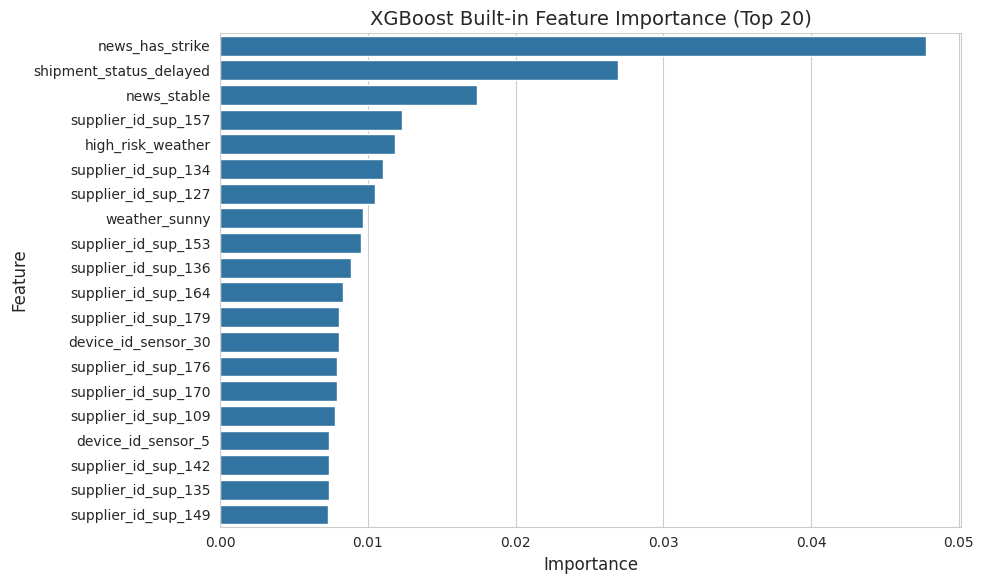


--- Model Interpretability Complete ---


In [ ]:
# --- 5.3 Model Interpretability (Built-in Feature Importances - Robust Version) ---
print("\n--- 5.3 Model Interpretability (Built-in Feature Importances) ---")

if hasattr(best_severity_model, 'feature_importances_'):
    builtin_importances = best_severity_model.feature_importances_
    feature_names_processed = list(X_test_processed_df.columns)

    feature_importance_df_builtin = pd.DataFrame({
        'Feature': feature_names_processed,
        'Importance': builtin_importances
    }).sort_values(by='Importance', ascending=False)

    print("\n  Top 10 Most Influential Features (XGBoost Built-in Importance):")
    display(feature_importance_df_builtin.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df_builtin.head(20))
    plt.title("XGBoost Built-in Feature Importance (Top 20)")
    plt.tight_layout()
    plt.show()

else:
    print("  XGBoost model does not have 'feature_importances_' attribute or is not properly trained.")
    print("  Cannot display built-in feature importance.")

print("\n--- Model Interpretability Complete ---")

In [ ]:
# --- 5.4 Risk Assessment Scorecard Implementation ---
print("\n--- 5.4 Risk Assessment Scorecard Implementation ---")

# Re-deriving needed engineered features on df_test_original for scorecard rules
# These are features that are inputs to the scorecard's rule-based logic but are not ML predictions
# Ensure these columns are available in df_test_original from the start of Phase 5.
df_test_original['inventory_is_low_flag'] = (df_test_original['inventory_status'].str.lower() == 'low').astype(int)
df_test_original['is_unreliable_supplier'] = (df_test_original['supplier_rating'] < 3.0).astype(int)
df_test_original['is_weekend_delivery'] = (df_test_original['expected_delivery_date'].dt.dayofweek >= 5).astype(int)
df_test_original['planned_transit_time_hours'] = (df_test_original['expected_delivery_date'] - df_test_original['order_placed_date']).dt.total_seconds() / 3600
df_test_original['planned_transit_time_hours'] = df_test_original['planned_transit_time_hours'].clip(lower=0)


# --- DEFINE ALL SCORECARD CALCULATION FUNCTIONS (FIRST) ---
# These functions define the logic for individual scorecard components.

# 1. Implement Cargo Criticality (assign_cargo_criticality)
def assign_cargo_criticality(row):
    pred_severity = row['predicted_delay_severity_score']
    supplier_risk = row['is_unreliable_supplier'] == 1
    inventory_low = row['inventory_is_low_flag'] == 1
    if pred_severity == 2:
        if supplier_risk and inventory_low: return 5
        elif supplier_risk or inventory_low: return 4
        else: return 3
    elif pred_severity == 1:
        if supplier_risk and inventory_low: return 3
        elif supplier_risk or inventory_low: return 2
        else: return 1
    else: return 0

# 2. Implement Business Impact (calculate_business_impact)
def calculate_business_impact(row):
    severity_to_impact_points = {0: 0, 1: 10, 2: 50}
    base_impact_points = severity_to_impact_points.get(row['predicted_delay_severity_score'], 0)

    inventory_penalty = 0
    if row['inventory_is_low_flag'] == 1:
        inventory_penalty = 20

    supplier_penalty = 0
    if row['is_unreliable_supplier'] == 1:
        supplier_penalty = 10

    weekend_delivery_penalty = 0
    if row['is_weekend_delivery'] == 1:
        weekend_delivery_penalty = 5

    total_impact = base_impact_points + inventory_penalty + supplier_penalty + weekend_delivery_penalty
    return total_impact

# 3. Probability of Delay Risk Rating (1-5)
def assign_prob_rating(prob):
    if 0.81 <= prob <= 1.00: return 5
    elif 0.61 <= prob <= 0.80: return 4
    elif 0.41 <= prob <= 0.60: return 3
    elif 0.21 <= prob <= 0.40: return 2
    else: return 1

# 4. Delay Duration (Severity Score) Risk Rating (1-5)
def assign_duration_rating(severity_score):
    if severity_score == 2: return 5
    elif severity_score == 1: return 3
    else: return 1

# 5. Cargo Criticality Risk Rating (1-5)
def assign_cargo_rating(criticality_score):
    return int(criticality_score) if 0 <= criticality_score <= 5 else 0

# 6. Business Impact Risk Rating (1-5)
def assign_impact_rating(impact_score):
    if impact_score > 60: return 5
    elif impact_score > 40: return 4
    elif impact_score > 20: return 3
    elif impact_score > 5: return 2
    else: return 1


# --- EXECUTE ALL SCORECARD CALCULATIONS ON df_test_original (IN ORDER) ---
print("\n  Executing scorecard calculations on df_test_original...")

# Step 1: Calculate raw components based on ML predictions and original features
df_test_original['cargo_criticality_score'] = df_test_original.apply(assign_cargo_criticality, axis=1)
print("  'cargo_criticality_score' calculated.")

df_test_original['business_impact_score'] = df_test_original.apply(calculate_business_impact, axis=1)
print("  'business_impact_score' calculated.")

# Step 2: Apply 1-5 risk ratings to all components (these use the raw scores/predictions)
df_test_original['probability_of_delay_rating'] = df_test_original['predicted_probability_of_delay'].apply(assign_prob_rating)
df_test_original['delay_duration_rating'] = df_test_original['predicted_delay_severity_score'].apply(assign_duration_rating)
df_test_original['cargo_criticality_rating'] = df_test_original['cargo_criticality_score'].apply(assign_cargo_rating)
df_test_original['business_impact_rating'] = df_test_original['business_impact_score'].apply(assign_impact_rating)
print("  Component risk ratings (1-5) applied.")

# Step 3: Map ratings/scores to descriptive labels for display (these use the ratings/scores)
prob_labels = {5: "Very High", 4: "High", 3: "Medium", 2: "Low", 1: "Very Low"}
duration_category_labels = {0: "No Delay", 1: "0-24 hrs", 2: ">24 hrs"}
cargo_labels = {5: "Critical", 4: "High", 3: "Medium", 2: "Low", 1: "Non-Critical", 0: "Non-Critical"}
impact_labels = {5: "Severe Financial + Ops Loss", 4: "Major Delivery Impact", 3: "Moderate Replanning Needed", 2: "Minimal Process Delay", 1: "No Noticeable Impact"}

df_test_original['probability_of_delay_category'] = df_test_original['probability_of_delay_rating'].map(prob_labels)
df_test_original['delay_duration_category'] = df_test_original['predicted_delay_severity_score'].map(duration_category_labels)
df_test_original['cargo_criticality_category'] = df_test_original['cargo_criticality_rating'].map(cargo_labels)
df_test_original['business_impact_category'] = df_test_original['business_impact_rating'].map(impact_labels)
print("  Descriptive labels mapped for scorecard display.")


# Step 4: Calculate Final Composite Risk Score
print("\n  Calculating Final Risk Score...")
w1_prob_rating = 0.20
w2_duration_rating = 0.30
w3_criticality_rating = 0.30
w4_impact_rating = 0.20

df_test_original['composite_weighted_score_raw'] = (
    w1_prob_rating * df_test_original['probability_of_delay_rating'] +
    w2_duration_rating * df_test_original['delay_duration_rating'] +
    w3_criticality_rating * df_test_original['cargo_criticality_rating'] +
    w4_impact_rating * df_test_original['business_impact_rating']
)

# Normalize Total Risk Score to a 0-5 scale as per mock-up
df_test_original['total_risk_score_0_5'] = df_test_original['composite_weighted_score_raw']

max_possible_composite = 5.0
print(f"  Composite Risk Score calculated (0-5 scale). Max possible: {max_possible_composite}")


--- 5.4 Risk Assessment Scorecard Implementation ---

  Executing scorecard calculations on df_test_original...
  'cargo_criticality_score' calculated.
  'business_impact_score' calculated.
  Component risk ratings (1-5) applied.
  Descriptive labels mapped for scorecard display.

  Calculating Final Risk Score...
  Composite Risk Score calculated (0-5 scale). Max possible: 5.0


In [ ]:
!pip install xlsxwriter # Uncomment if xlsxwrite is not install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 14.2 MB/s eta 0:00:00



--- 5.4.5 Visualizing Scorecard Output ---

  Distribution of Total Risk Score (0-5):


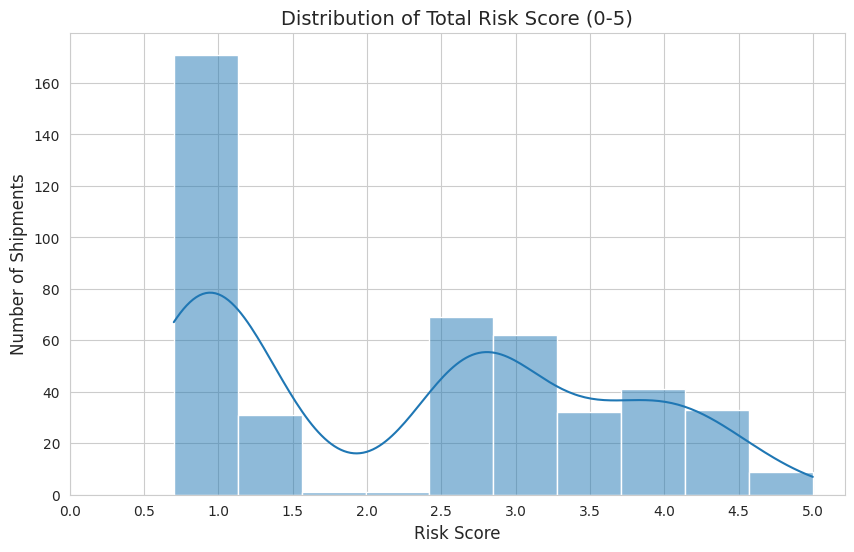


  Top 10 Riskiest Shipments (Final Scorecard View):


,shipment_id,Probability of Delay (Value),Probability of Delay (Category),Delay Duration (Category),Cargo Criticality,Business Impact,Weights,Weighted Score,Total Risk Score
2719,SHP02719,0.994930,Very High,>24 hrs,Critical,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.99*0.20) + (5*0.30) + (5*0.30) + (5*0.20),5.00 / 5.00
2736,SHP02736,0.843538,Very High,>24 hrs,Critical,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.84*0.20) + (5*0.30) + (5*0.30) + (5*0.20),5.00 / 5.00
2883,SHP02883,0.991128,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.99*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2672,SHP02672,0.948915,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.95*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2965,SHP02965,0.981835,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.98*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2955,SHP02955,0.998091,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(1.00*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2647,SHP02647,0.996569,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(1.00*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2562,SHP02562,0.822502,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.82*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2677,SHP02677,0.997653,Very High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(1.00*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.70 / 5.00
2951,SHP02951,0.618040,High,>24 hrs,High,Severe Financial + Ops Loss,"(20.0%, 30.0%, 30.0%, 20.0%)",(0.62*0.20) + (5*0.30) + (4*0.30) + (5*0.20),4.50 / 5.00



--- Risk Assessment Scorecard Implementation Complete ---

--- Phase 5: Evaluation & Scorecard Integration Complete ---
Script execution finished successfully!

Final Scorecard Data Info (sample of test set):
<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 2550 to 2999
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   timestamp                        450 non-null    datetime64[ns]
 1   device_id                        450 non-null    object        
 2   location                         450 non-null    object        
 3   temperature                      450 non-null    float64       
 4   humidity                         450 non-null    float64       
 5   vibration_level                  450 non-null    float64       
 6   inventory_status                 450 non-null    object        
 7   stock_quantity                   450 non-null    int64      

,timestamp,device_id,location,temperature,humidity,vibration_level,inventory_status,stock_quantity,order_id,order_placed_date,...,probability_of_delay_rating,delay_duration_rating,cargo_criticality_rating,business_impact_rating,probability_of_delay_category,delay_duration_category,cargo_criticality_category,business_impact_category,composite_weighted_score_raw,total_risk_score_0_5
2550,2024-05-02 06:23:38,sensor_27,warehouse_a,28.25,66.42,3.49,in-stock,304,ord5931,2024-04-22 06:23:38,...,5,3,2,3,Very High,0-24 hrs,Low,Moderate Replanning Needed,3.1,3.1
2551,2025-03-16 01:39:12,sensor_27,warehouse_a,29.73,49.21,0.24,in-stock,183,ord8502,2025-03-08 01:39:12,...,4,1,0,2,High,No Delay,Non-Critical,Minimal Process Delay,1.5,1.5
2552,2025-02-18 21:25:30,sensor_42,hub_c,16.22,54.35,0.40,in-stock,73,ord2998,2025-02-06 21:25:30,...,1,1,0,1,Very Low,No Delay,Non-Critical,No Noticeable Impact,0.7,0.7
2553,2024-04-03 09:34:16,sensor_6,port_b,30.00,65.02,0.25,in-stock,74,ord9994,2024-03-22 09:34:16,...,2,1,0,1,Low,No Delay,Non-Critical,No Noticeable Impact,0.9,0.9
2554,2024-05-01 11:51:02,sensor_14,port_b,23.22,34.96,2.90,in-stock,394,ord5577,2024-04-24 11:51:02,...,2,1,0,2,Low,No Delay,Non-Critical,Minimal Process Delay,1.1,1.1



Final scorecard data exported to 'final_scorecard_data.xlsx' with multiple sheets.


In [ ]:
# --- 5.4.5 Visualize Scorecard Output ---
print("\n--- 5.4.5 Visualizing Scorecard Output ---")

print("\n  Distribution of Total Risk Score (0-5):")
plt.figure(figsize=(10, 6))
sns.histplot(df_test_original['total_risk_score_0_5'], bins=10, kde=True) # 10 bins for 0-5 scale
plt.title('Distribution of Total Risk Score (0-5)')
plt.xlabel('Risk Score')
plt.ylabel('Number of Shipments')
plt.xticks(np.arange(0, 5.1, 0.5)) # Set x-ticks for better clarity on 0-5 scale
plt.show()

print("\n  Top 10 Riskiest Shipments (Final Scorecard View):")
# Directly select columns for display, as they are guaranteed to exist on df_test_original
final_scorecard_display = df_test_original[[
    'shipment_id',
    'predicted_probability_of_delay', 'probability_of_delay_category',
    'predicted_delay_severity_score', 'delay_duration_category',
    'cargo_criticality_category',
    'business_impact_category',
    'composite_weighted_score_raw',
    'total_risk_score_0_5',
    'probability_of_delay_rating',
    'delay_duration_rating',
    'cargo_criticality_rating',
    'business_impact_rating'
]].sort_values(by='total_risk_score_0_5', ascending=False).head(10).copy() # .copy() for safety with new columns

# Pre-format the weights string outside the .apply()
weights_display_string = f"({w1_prob_rating*100}%, {w2_duration_rating*100}%, {w3_criticality_rating*100}%, {w4_impact_rating*100}%)"

final_scorecard_display['Weights'] = weights_display_string # Assign the pre-formatted string

# Format 'Weighted Score' detail string
final_scorecard_display['Weighted Score (Calc Detail)'] = final_scorecard_display.apply(
    lambda row: f"({row['predicted_probability_of_delay']:.2f}*{w1_prob_rating:.2f}) + ({row['delay_duration_rating']:.0f}*{w2_duration_rating:.2f}) + ({row['cargo_criticality_rating']:.0f}*{w3_criticality_rating:.2f}) + ({row['business_impact_rating']:.0f}*{w4_impact_rating:.2f})", axis=1
)

final_scorecard_display['Total Risk Score (Display)'] = final_scorecard_display['total_risk_score_0_5'].apply(lambda x: f"{x:.2f} / 5.00")


# Select and rename columns for final display to match mock-up as closely as possible
final_scorecard_display = final_scorecard_display[[
    'shipment_id',
    'predicted_probability_of_delay', 'probability_of_delay_category',
    'delay_duration_category',
    'cargo_criticality_category',
    'business_impact_category',
    'Weights',
    'Weighted Score (Calc Detail)',
    'Total Risk Score (Display)'
]]

# Final column renaming for direct presentation match
final_scorecard_display.rename(columns={
    'predicted_probability_of_delay': 'Probability of Delay (Value)',
    'probability_of_delay_category': 'Probability of Delay (Category)',
    'delay_duration_category': 'Delay Duration (Category)',
    'cargo_criticality_category': 'Cargo Criticality',
    'business_impact_category': 'Business Impact',
    'Weighted Score (Calc Detail)': 'Weighted Score',
    'Total Risk Score (Display)': 'Total Risk Score'
}, inplace=True)

display(final_scorecard_display)


print("\n--- Risk Assessment Scorecard Implementation Complete ---")


print("\n--- Phase 5: Evaluation & Scorecard Integration Complete ---")
print("Script execution finished successfully!")

# Final check of the scorecard data types and info
print("\nFinal Scorecard Data Info (sample of test set):")
df_test_original.info()
print("\nSample Head of Final Scorecard Data (Full Data for Export):") # Use this for export
display(df_test_original.head())

# Export to excel
excel_output_path = "final_scorecard_data.xlsx"
writer = pd.ExcelWriter(excel_output_path, engine='xlsxwriter') # If error arises, install xlsxwriter (uncomment !pip install xlsxwriter)

# Sheet 1: Detailed Scorecard Data
df_test_original.to_excel(writer, sheet_name='Shipment_Scorecard_Detailed', index=False)

# Sheet 2: Raw Data for Aggregation (for monthly/quarterly insights)
# This sheet contains raw predictions and core identifiers for aggregation in Excel.
df_for_aggregation = df_test_original[[
    'timestamp',
    'shipment_id',
    'predicted_probability_of_delay',
    'predicted_delay_severity_score',
    'cargo_criticality_score', # Raw calculated criticality score (0-5)
    'business_impact_score', # Raw calculated business impact score
    'total_risk_score_0_5', # The final 0-5 risk score
]].copy()

# Add Month and Quarter columns directly in Python for easier pivoting in Excel
df_for_aggregation['month'] = df_for_aggregation['timestamp'].dt.month
df_for_aggregation['quarter'] = df_for_aggregation['timestamp'].dt.quarter
df_for_aggregation['year'] = df_for_aggregation['timestamp'].dt.year

df_for_aggregation.to_excel(writer, sheet_name='Aggregated_Data_Raw', index=False)

# Save the Excel file
writer.close()
print(f"\nFinal scorecard data exported to '{excel_output_path}' with multiple sheets.")